In [26]:
topology_file = '../out/sim/sequence_length1000/lsd-tree.date.newick'
beast_result_file = '../out/sim/sequence_length1000/beast-relaxed-fixed.pickle'
correlation_plot_out_file = '../out/sim/sequence_length1000/rate-correlations-scaled.png'
marginal_plot_out_file = '../out/sim/sequence_length1000/marginals-scaled.png'
rate_marginal_plot_out_file = '../out/sim/sequence_length1000/rate-marginals-scaled.png'
variational_fit_file = '../out/sim/sequence_length1000/variational-relaxed-scaled.pickle'
prior_params_file = '../config/prior-params.yaml'
clock_approx = 'scaled'

In [2]:
from treeflow_pipeline.util import pickle_input, yaml_input

beast_result = pickle_input(beast_result_file)
variational_fit = pickle_input(variational_fit_file)

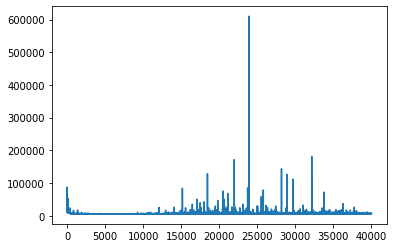

In [3]:
import matplotlib.pyplot as plt
plt.plot(variational_fit['loss'])

In [4]:
len(variational_fit['params'])

10

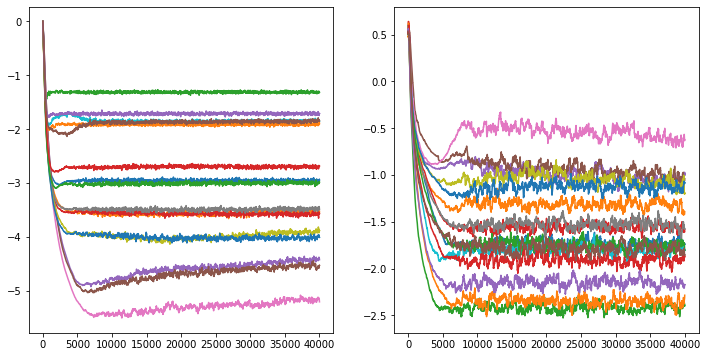

In [5]:
n_branches = beast_result['branch_lengths'].shape[1]
rate_var_traces = [x for x in variational_fit['params'] if x.shape[-1] == n_branches] # TODO: How can we make sure we get the right variables?
fig, axs = plt.subplots(ncols=len(rate_var_traces), figsize=(12, 6))
for ax, rate_var_trace in zip(axs, rate_var_traces):
    ax.plot(rate_var_trace)

In [6]:
import treeflow_pipeline.model

approx = treeflow_pipeline.model.reconstruct_approx(topology_file, variational_fit, yaml_input(prior_params_file), 'relaxed', clock_approx)

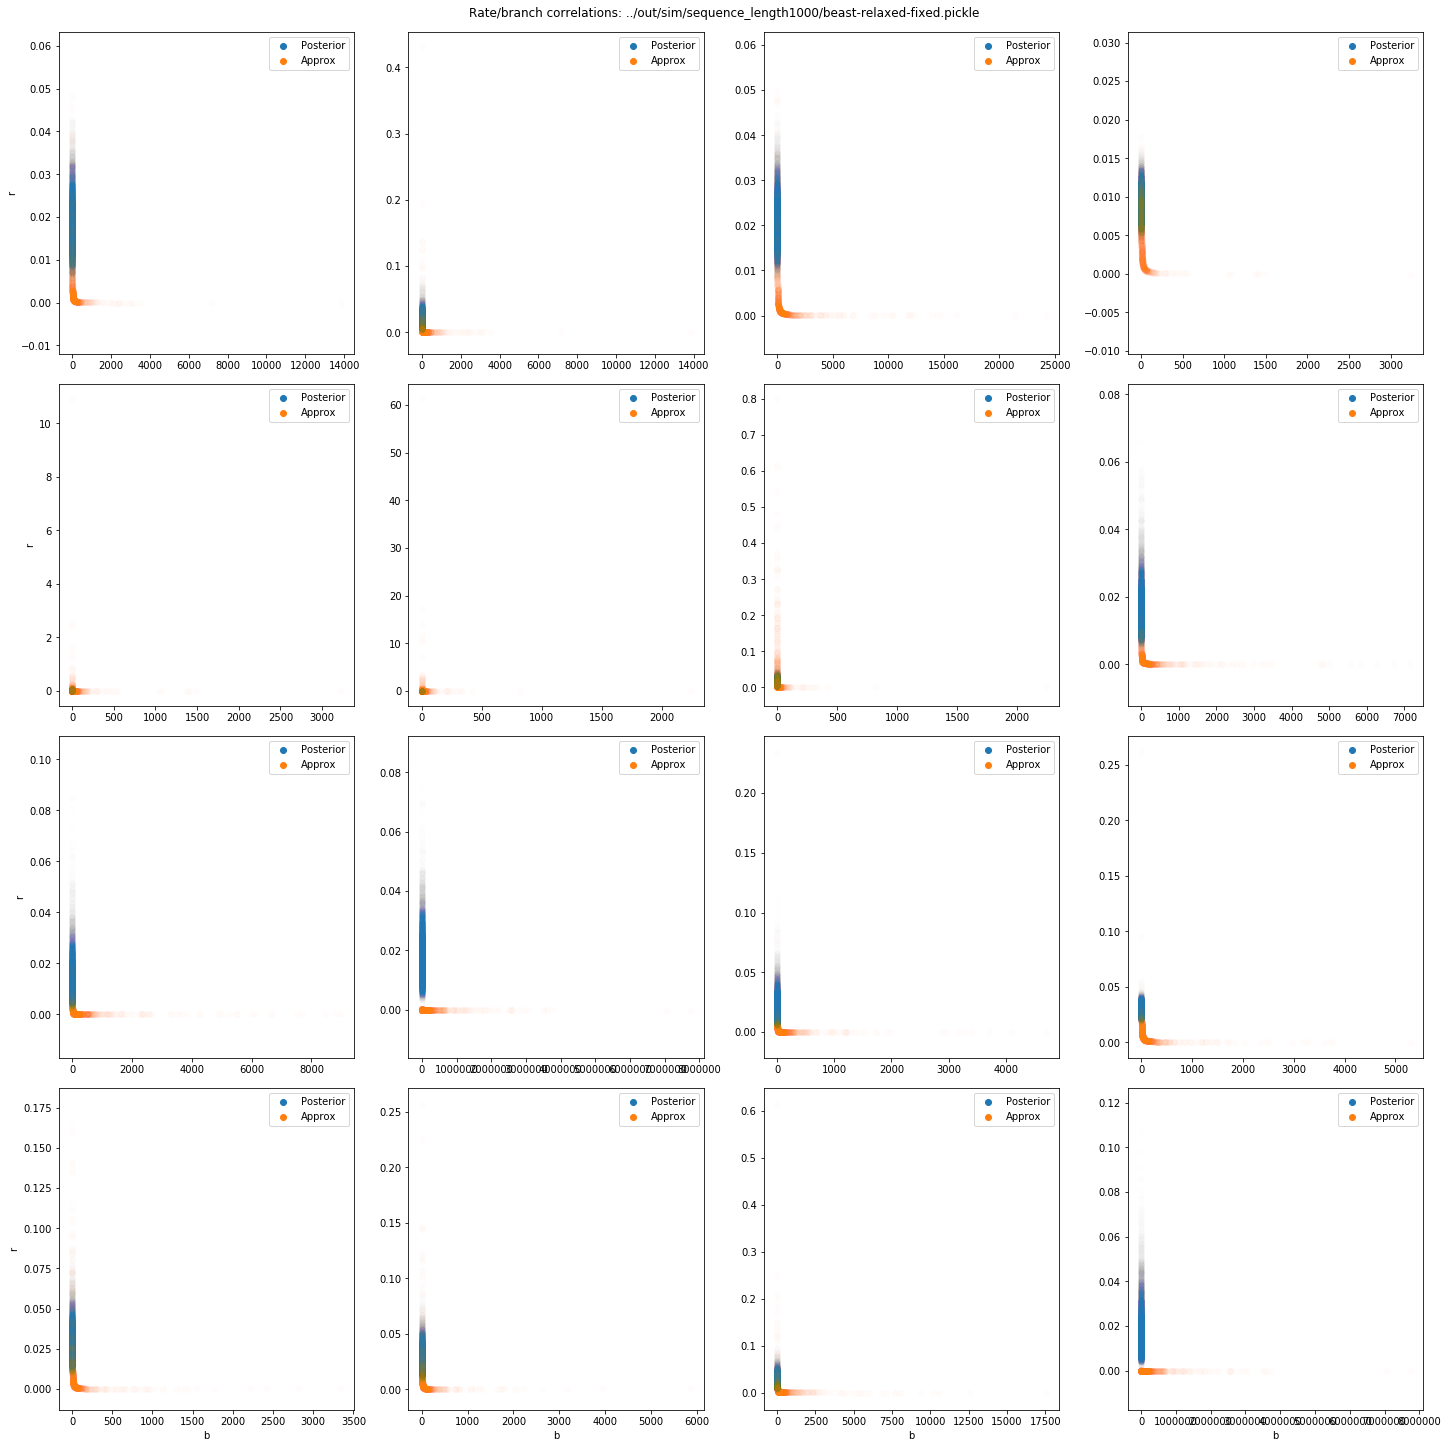

In [23]:
import treeflow.sequences

n_cols = 4
n_rows = n_branches // n_cols

approx_samples = approx.sample(1000)
approx_blens = treeflow.sequences.get_branch_lengths(approx_samples['tree'])
approx_rates_t = approx_samples['clock_rate'].numpy() * approx_samples['rates'].numpy().T
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]
for ax, branch_blens, branch_rates, approx_blens, approx_rates in zip(axs_flat, beast_result['branch_lengths'].T, beast_result['absolute_rates'].T, approx_blens.numpy().T, approx_rates_t):
    ax.scatter(branch_blens, branch_rates, alpha=0.005, label='Posterior')
    ax.scatter(approx_blens, approx_rates, alpha=0.01, label='Approx')
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

for ax in axs[-1]:
    ax.set_xlabel('b')

for row in axs:
    row[0].set_ylabel('r')

plt.suptitle('Rate/branch correlations: ' + beast_result_file);
plt.savefig(correlation_plot_out_file)

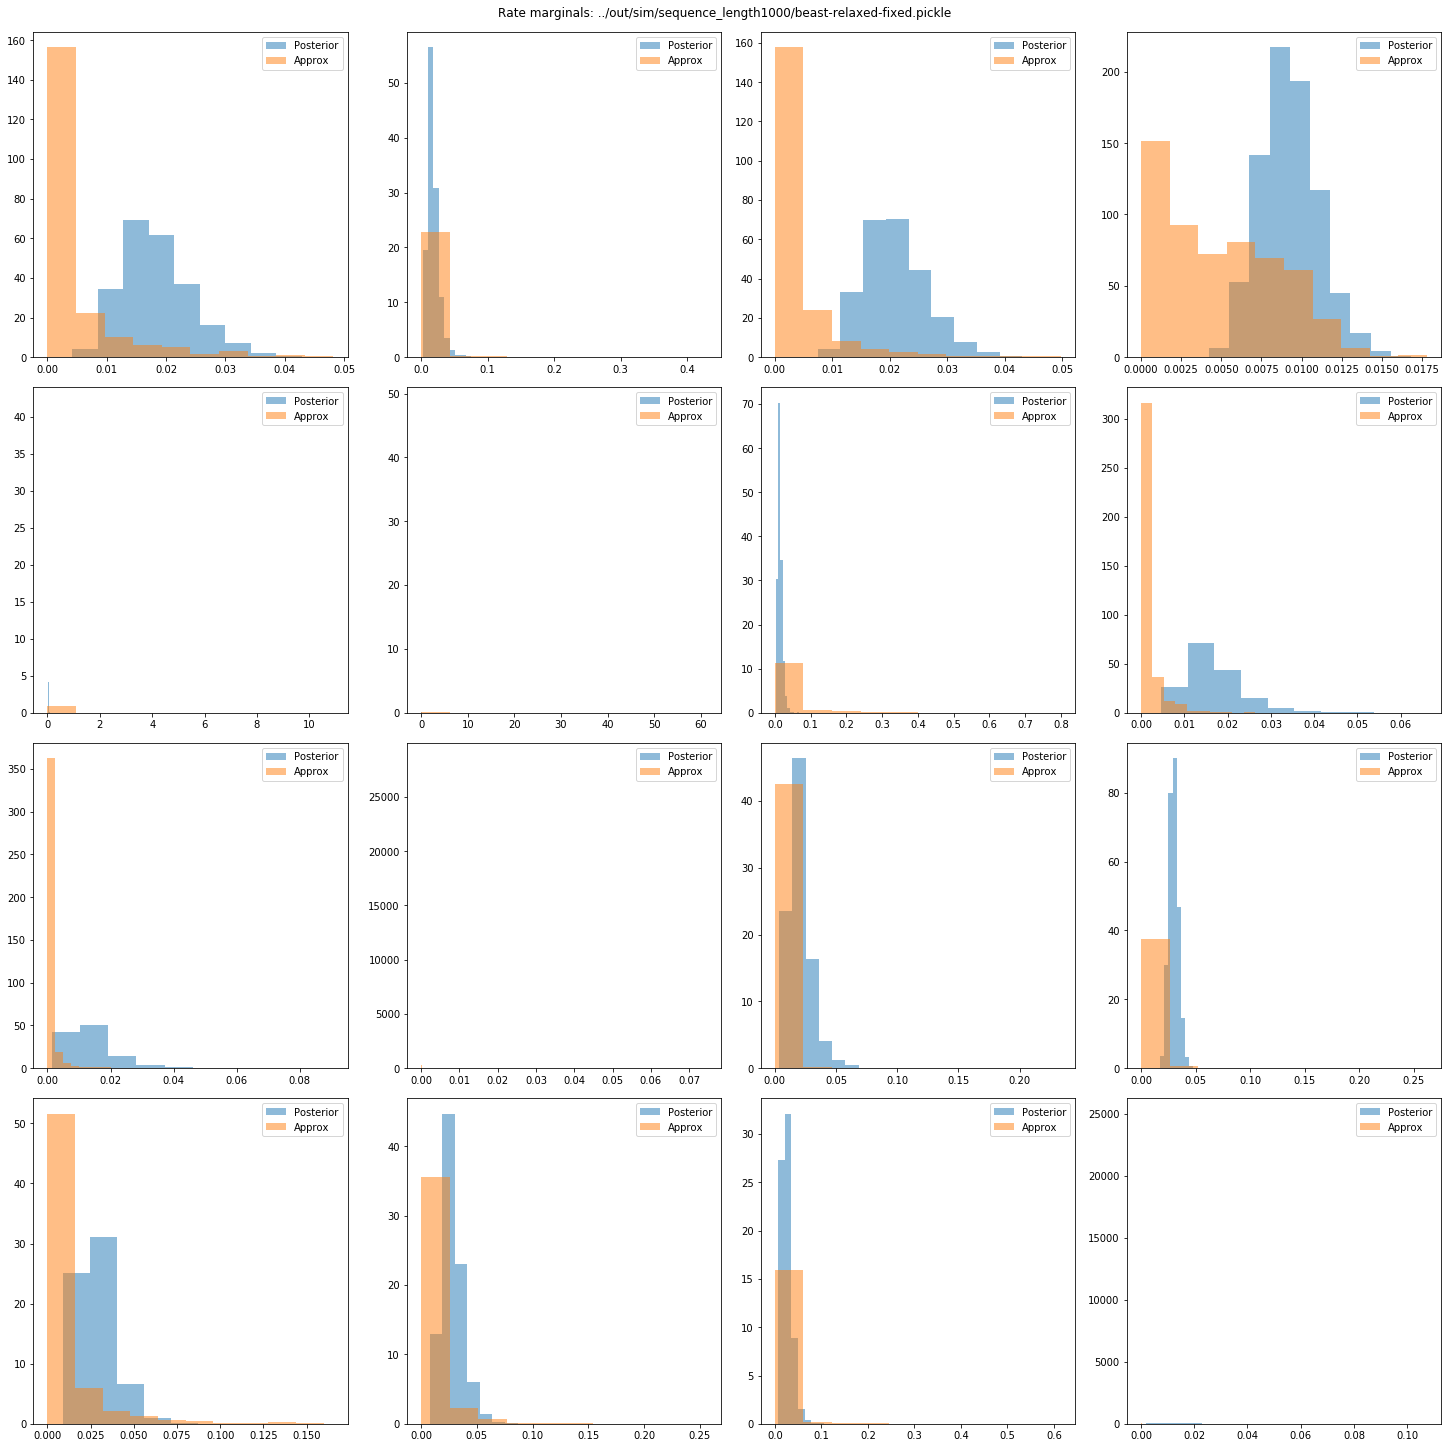

In [28]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

for ax, branch_rates, approx_rates, in zip(axs_flat, beast_result['absolute_rates'].T, approx_rates_t):
    ax.hist(branch_rates, alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_rates, alpha=0.5, label='Approx', density=True)
    leg = ax.legend()


plt.suptitle('Absolute rate marginals: ' + beast_result_file);

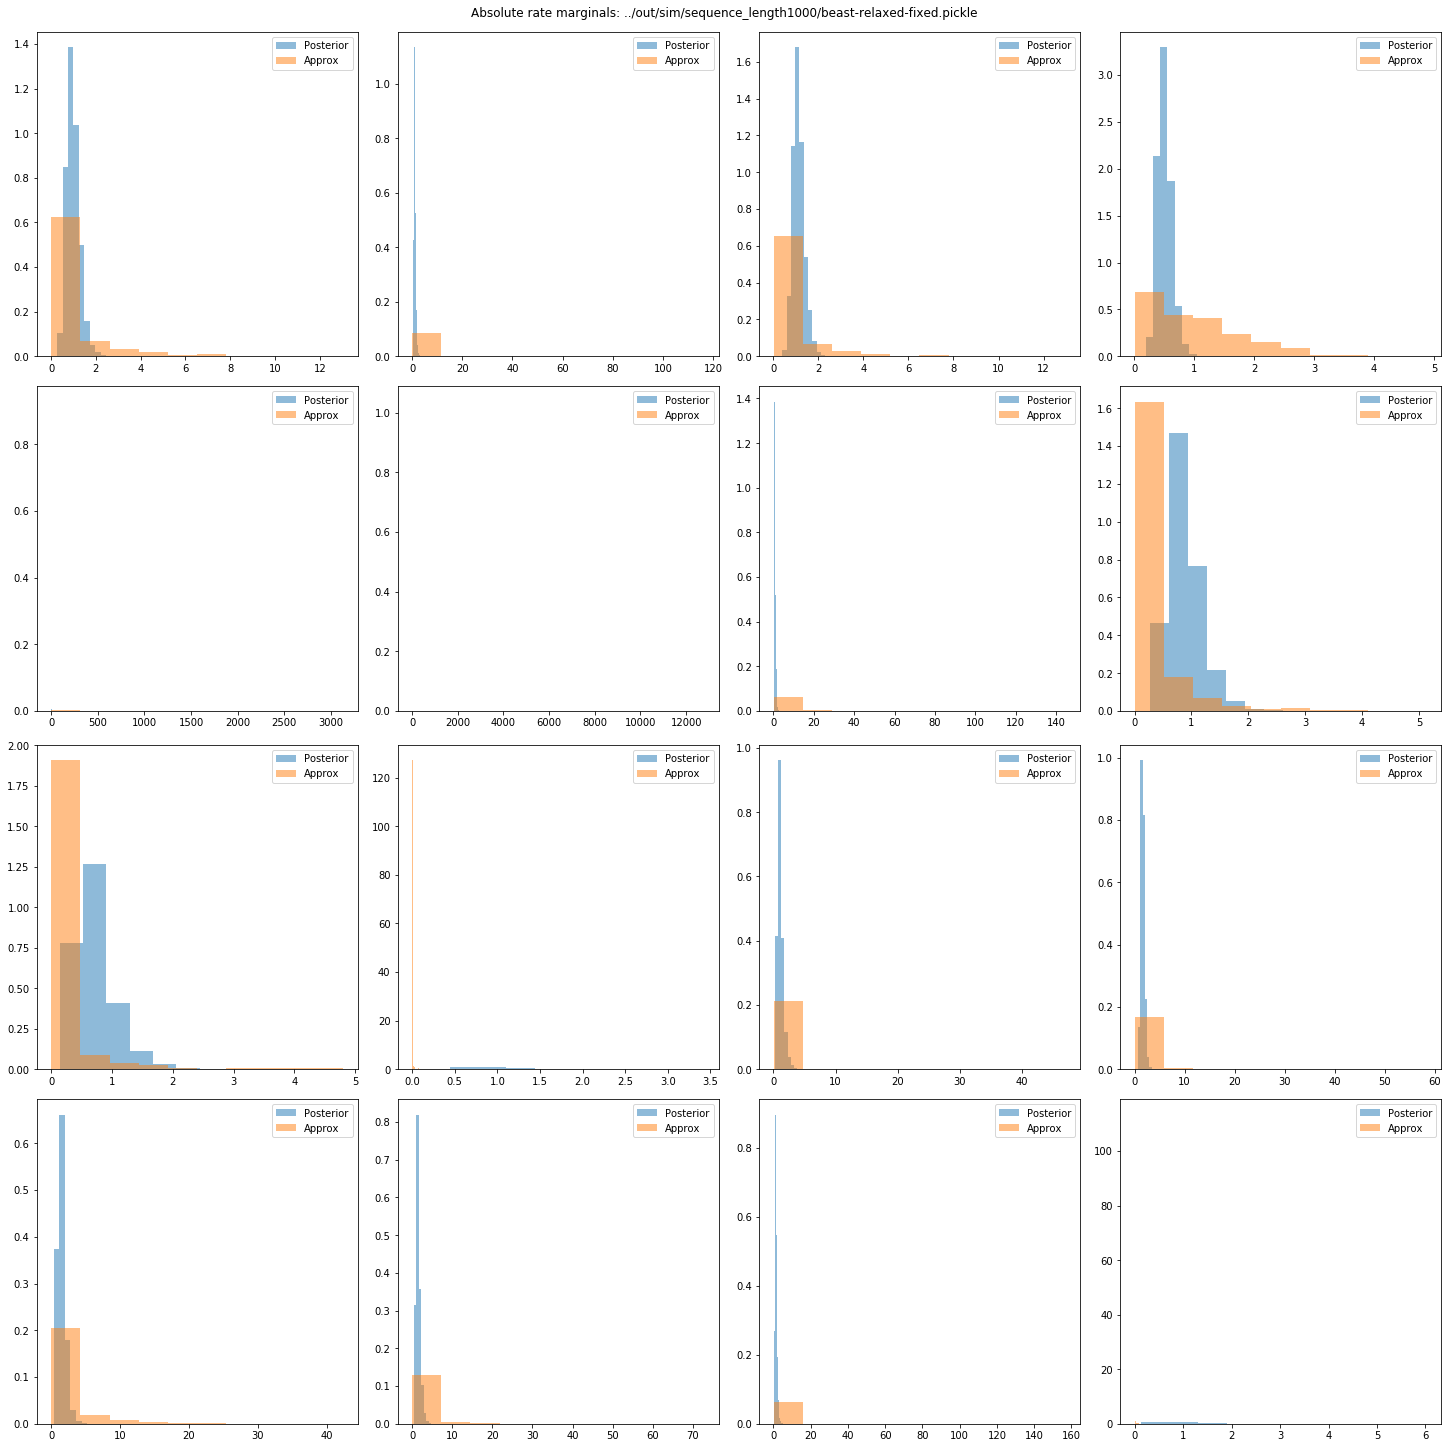

In [29]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

for ax, branch_rates, approx_rates, in zip(axs_flat, beast_result['rates'].T, approx_samples['rates'].numpy().T):
    ax.hist(branch_rates, alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_rates, alpha=0.5, label='Approx', density=True)
    leg = ax.legend()


plt.suptitle('Relative rate marginals: ' + beast_result_file);
plt.savefig(rate_marginal_plot_out_file)

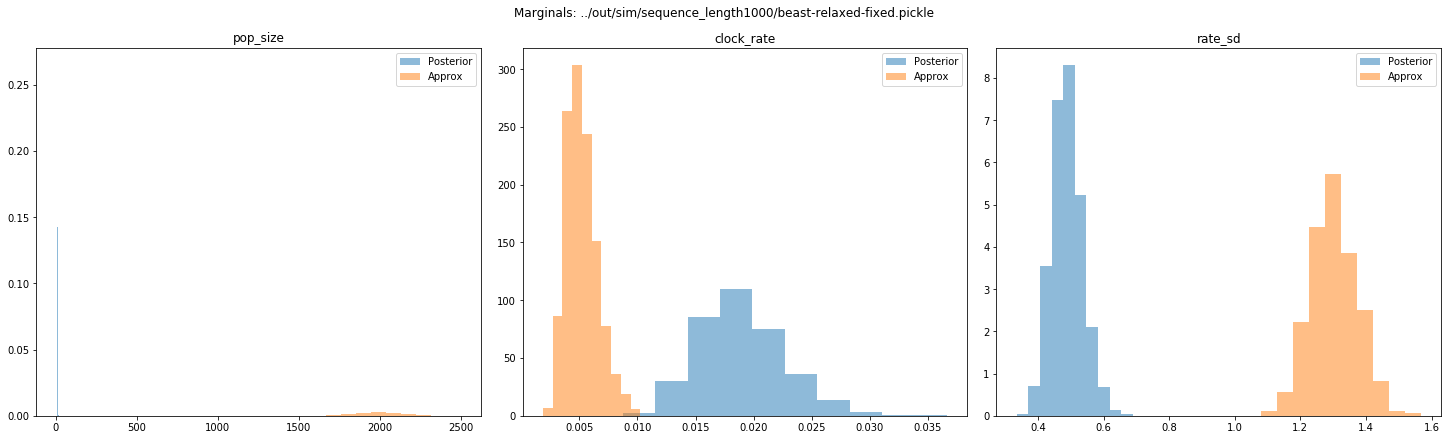

In [27]:
other_vars = ['pop_size', 'clock_rate', 'rate_sd']
fig, axs = plt.subplots(ncols=len(other_vars), figsize=(20, 6), constrained_layout=True)
for var, ax in zip(other_vars, axs):
    ax.set_title(var)
    ax.hist(beast_result[var], alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_samples[var], alpha=0.5, label='Approx', density=True)
    leg = ax.legend()
    
plt.suptitle('Marginals: ' + beast_result_file);
plt.savefig(marginal_plot_out_file)